#Task 1:

In [1]:
url = "https://cloud.tu-ilmenau.de/s/8EZfAjwPFPxFSrw/download/utils.py"
!wget -nv -t 0 --show-progress $url
import utils

utils.py                [ <=>                ]   4.93K  --.-KB/s    in 0s      
2024-06-27 08:02:02 URL:https://cloud.tu-ilmenau.de/s/8EZfAjwPFPxFSrw/download/utils.py [5053] -> "utils.py" [1]


#Task 2: Text Vectorization

In [2]:
train_ds, val_ds, class_names = utils.load_ag_news()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.72AQ7S_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.72AQ7S_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.
Train samples = 120000
Test samples = 7600


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [4]:
from utils import extract_text, return_input_only

# Create a character-level TextVectorization Layer to convert characters into integers numbers.
max_vocab_size = 10000
max_sequence_length = 100

vectorizer = TextVectorization(max_tokens=max_vocab_size,
                               split = 'character',
                               output_sequence_length = max_sequence_length,)

vectorizer.adapt(train_ds.take(50).map(utils.return_input_only))

In [5]:
"""
Print the resulting vocabulary size and the first 10 elements of the vocabulary.
"""
# Get the unique characters in the vocabulary
vocab = vectorizer.get_vocabulary()

# Length of the vocabulary
vocab_size = len(vocab)
print(f"Number of words in vocab: {vocab_size}")

# First 10 characters
first_10_char = vocab[:10]
print(f"first 10 chars: {first_10_char}")

Number of words in vocab: 39
first 10 chars: ['', '[UNK]', ' ', 'e', 'a', 't', 'o', 'i', 's', 'n']


In [6]:
"""
Make up a sentence and use your adapted TextVectorization layer to convert it into a numerical
representation.
"""
example_sentence = "I like deep learning"
vectorizer([example_sentence])

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 7,  2, 11,  7, 24,  3,  2, 12,  3,  3, 18,  2, 11,  3,  4, 10,
         9,  7,  9, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])>

In [7]:
def vectorize_text(text, label):
    """
    ChatGPT reference taken here to build this function;
    Prompts:
    1 - how to access training examples or rather a single training sample from Tensorflow datasets?
    2 - how to apply vectorization to training examples as a pre-processing step?
    """
    text = tf.expand_dims(text, -1)  # Expand dimensions to match the input shape
    text = vectorizer(text)
    #text = tf.cast(text, tf.int64)
    print(text.shape)
    return tf.squeeze(text, axis=0), label

train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

(1, 100)
(1, 100)


In [8]:
"""
optimize the training and validation datasets for performance by
• caching the dataset in memory,
• shuffling of the training data with a buffer size of 1000,
• batching the data with a batch size of 128,
• and prefetching
in the given order.
"""
BATCHSIZE = 128
AUTOTUNE = tf.data.AUTOTUNE


train_ds_opt = train_ds.cache().shuffle(1000).batch(BATCHSIZE).prefetch(AUTOTUNE)

val_ds_opt = val_ds.cache().batch(BATCHSIZE).prefetch(AUTOTUNE)

In [9]:
for example, label in train_ds_opt.take(1):
    print("Text:", example.numpy())
    print("Label:", label.numpy())

Text: [[ 4 10  3 ...  2  5 10]
 [20 15 24 ...  3 12  2]
 [12  6 11 ...  2  2  5]
 ...
 [24  3 20 ...  9  9  3]
 [ 8  6 10 ... 20  3  4]
 [ 9  3 21 ...  7 12  3]]
Label: [1 2 2 3 2 1 3 2 3 2 0 1 0 3 2 1 2 0 1 3 0 1 0 1 1 3 0 1 0 3 0 2 0 1 0 2 3
 3 1 1 3 0 3 2 3 1 1 0 1 0 0 1 2 2 2 0 1 1 0 1 1 1 3 0 3 2 2 0 0 3 0 1 2 3
 3 3 1 0 3 1 2 3 3 2 2 2 1 2 1 3 0 1 2 0 2 3 3 3 0 2 2 2 2 2 2 3 1 1 3 0 1
 1 2 2 1 1 0 2 3 2 1 0 0 3 3 1 2 3]


#Task 3: Bag-of-Characters Model

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from utils import TruncateLayer

def build_boc_model(vectorizer, vocab_size, num_classes):


  input = layers.Input(shape=(1,), dtype=tf.int64)

 # x = vectorizer(input)

  x = layers.Embedding(input_dim = vocab_size, output_dim = 4)(input)

  # Truncate Lyaer from utils.py
  x = TruncateLayer(max_length = 100)(x)

  # GlobalAveragePooling1D
  x = layers.GlobalAveragePooling1D()(x)

  output = layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.models.Model(input, output)
  model.compile(
      loss= SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  model.summary()

  return model

# Embedding Layer
#### The reason I chose Embedding layer is simply because of the dimensionality reduction it provides in contrast to a one-hot encoding layer which is not memory efficient.

#### Explanantion:
##### Considering the assignment, we have a vocabulary of about 39 characters, in the training set every character will be represented by a vector of size 100 because we set the output_sequence in our TextVectorizer to be 100. If a sample from the training set has `250` characters then the vector would be of size `250 X 100 = 250000`. On the other hand an Embedding layer gives us the luxury to represent each character by a user-defined dimension which in our case is `4` so `250 X 4 = 1000` which is equal to `99.6%` dimensionality reduction.This allows efficient usage of memory.

In [ ]:
boc_model = build_boc_model(vectorizer, max_vocab_size, len(class_names))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 4)              40000     
                                                                 
 truncate_layer (TruncateLa  (None, 1, 4)              0         
 yer)                                                            
                                                                 
 global_average_pooling1d (  (None, 4)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
Total params: 40020 (156.33 KB)
Trainable params: 40020 (156.

In [ ]:
boc_history = boc_model.fit(
    train_ds_opt,
    validation_data = val_ds_opt,
    epochs=10
)

Epoch 1/10
938/938 [==============================] - 30s 30ms/step - loss: 1.3596 - sparse_categorical_accuracy: 0.3909 - val_loss: 1.3206 - val_sparse_categorical_accuracy: 0.4301
Epoch 2/10
938/938 [==============================] - 3s 4ms/step - loss: 1.2831 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.2642 - val_sparse_categorical_accuracy: 0.4393
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 1.2462 - sparse_categorical_accuracy: 0.4444 - val_loss: 1.2448 - val_sparse_categorical_accuracy: 0.4434
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 1.2309 - sparse_categorical_accuracy: 0.4507 - val_loss: 1.2344 - val_sparse_categorical_accuracy: 0.4484
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 1.2218 - sparse_categorical_accuracy: 0.4545 - val_loss: 1.2275 - val_sparse_categorical_accuracy: 0.4517
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 1.2164 - sparse_categori

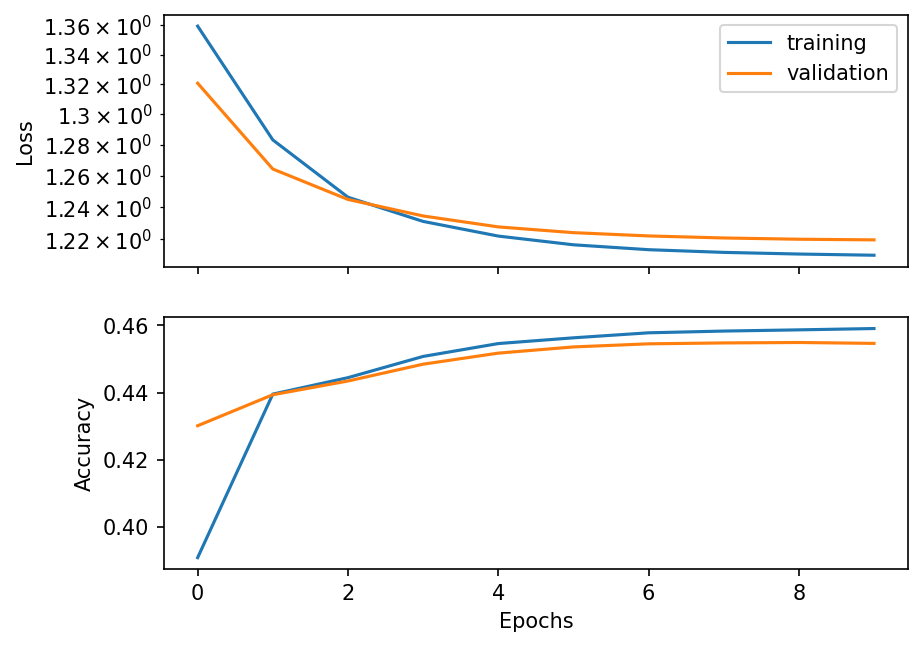

In [ ]:
utils.plot_history(boc_history)

#`Why the poor performance?`
Following are my reasons why the performance might be poor:
1. The model architecture is really simple as we are just training the randomly initialized Embedding which is just a representation of characters in a fixed shape and then classifying text using it.
2. Number of epochs could be another reason. We could try and train the model for longer epochs to see if the error rate decreases as we can observe it is gradually decreasing along with val_loss.
3. Embedding output dimensions are small, which  We could try and increase the number of dimensions and re-train the model to see if it improves.

#4 - GRU Model

In [ ]:
def build_gru_model(vectorizer, vocab_size, num_classes, hidden_size):


  input = layers.Input(shape=(1,), dtype=tf.int64)

  x = layers.Embedding(input_dim = vocab_size,output_dim = 4,)(input)

  x = TruncateLayer(max_length = 50)(x)

  x = layers.GRU(hidden_size)(x)

  output = layers.Dense(4, activation='softmax')(x)

  model = tf.keras.models.Model(input, output)

  model.compile(
      loss= SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  model.summary()

  return model

In [ ]:
def build_and_train_gru(hidden_size):
  gru_model = build_gru_model(vectorizer, max_vocab_size, len(class_names), hidden_size)


  gru_history = gru_model.fit(
      train_ds_opt,
      validation_data = val_ds_opt,
      epochs=10
  )

  return gru_history, f"GRU_{hidden_size}"

In [ ]:
histories = []
labels = []

hidden_sizes = [16, 32, 64]
for hidden_size in hidden_sizes:
  history, label = build_and_train_gru(hidden_size)
  histories.append(history)
  labels.append(label)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 1, 4)              40000     
                                                                 
 truncate_layer_1 (Truncate  (None, 1, 4)              0         
 Layer)                                                          
                                                                 
 gru_1 (GRU)                 (None, 16)                1056      
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 41124 (160.64 KB)
Trainable params: 41124 (160.64 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

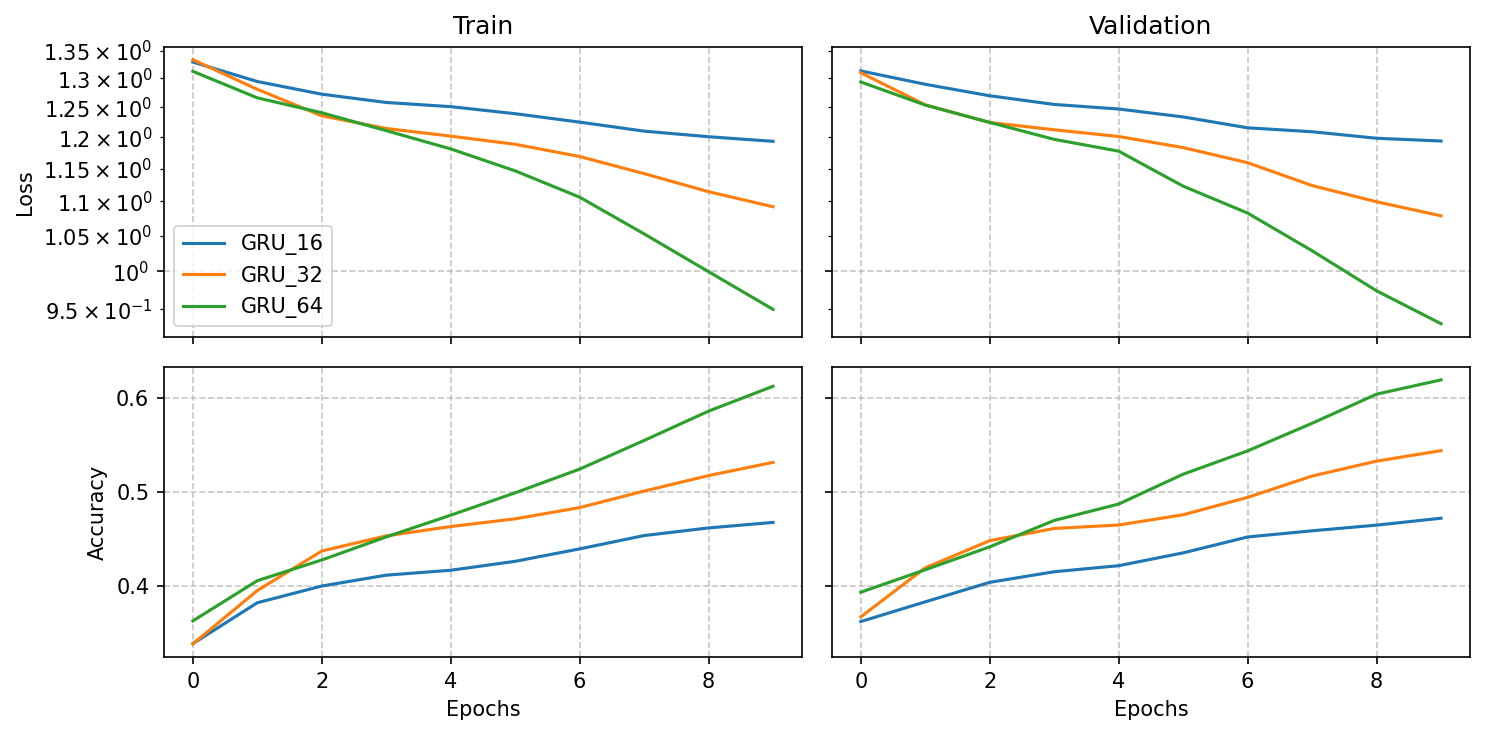

In [ ]:
utils.plot_multiple_histories(histories, labels)

# Observations:
### We can observe a significant increase in accuracy from the previous model, as GRU is a type of RNN it employs the concept of Memory which was not present in our previous model. The concept of Memory makes the model more complex and thus more room for learning and improving. It is also observed that, with increasing number of hidden units the model improves substantially in terms of accuracy from 40% to a little over 60% for both training and validation datasets.

#5 - Stacked GRUs

In [14]:
def build_gru_model_v2(vectorizer, vocab_size, num_classes, num_gru_layers):


  input = layers.Input(shape=(1,), dtype=tf.int64)

  x = layers.Embedding(input_dim = vocab_size, output_dim = 4,)(input)

  x = TruncateLayer(max_length = 50)(x)

  if num_gru_layers == 2:
    x = layers.GRU(16)(x)
    x = layers.GRU(16)(tf.expand_dims(x, axis = 1))

  if num_gru_layers == 3:
    x = layers.GRU(16)(x)
    print(x.shape)
    x = layers.GRU(16)(tf.expand_dims(x, axis = 1))
    x = layers.GRU(16)(tf.expand_dims(x, axis = 1))

  if num_gru_layers == 4:
    x = layers.GRU(16)(x)
    x = layers.GRU(16)(tf.expand_dims(x, axis = 1))
    x = layers.GRU(16)(tf.expand_dims(x, axis = 1))
    x = layers.GRU(16)(tf.expand_dims(x, axis = 1))


  output = layers.Dense(4, activation='softmax')(x)

  model = tf.keras.models.Model(input, output)

  model.compile(
      loss= SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  model.summary()

  return model


def build_and_train_gru_v2(num_gru_layers):
  gru_model = build_gru_model_v2(vectorizer, max_vocab_size, len(class_names), num_gru_layers)


  gru_history = gru_model.fit(
      train_ds_opt,
      validation_data = val_ds_opt,
      epochs=10
  )

  return gru_history, f"{num_gru_layers}_GRU_layers"

In [15]:
historiesv2 = []
labelsv2 = []
gru_layers = [2, 3, 4]
for layer in gru_layers:
  history, label = build_and_train_gru_v2(num_gru_layers=layer)
  historiesv2.append(history)
  labelsv2.append(label)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 4)              40000     
                                                                 
 truncate_layer (TruncateLa  (None, 1, 4)              0         
 yer)                                                            
                                                                 
 gru (GRU)                   (None, 16)                1056      
                                                                 
 tf.expand_dims (TFOpLambda  (None, 1, 16)             0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 16)                1632  

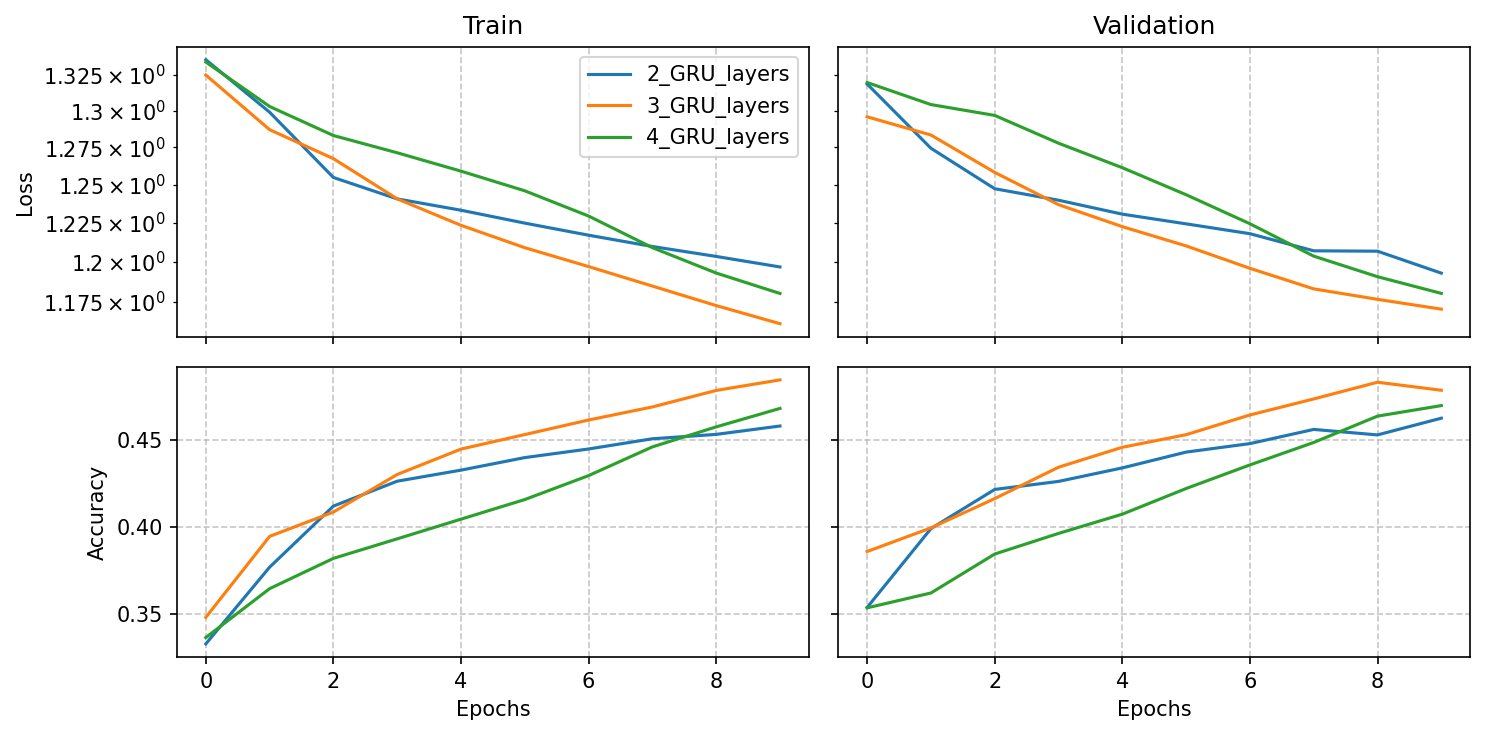

In [16]:
utils.plot_multiple_histories(historiesv2, labelsv2)

#Observations
###We can observe that increasing the number of GRU layers with hidden size 16 does not improve the model performance, which suggests that increasing the depth of the model introduces more complexity and thus ,as a known problem with RNNs in general, Vanishing gradients. Increasing depth does not reflect the same learning capacity as the increase in the hidden units, because if we increase the number of hidden units only, we introduce more learning parameters and if we increase the depth with same number of hiddent units, it adds more layers and approximately same amount of trainable parameters and it becomes relatively harder to compute non-existent gradients when backpropagating in time. But we can differentiate how each model with different GRU layers converges to the local minima.

1. 2 and 3 layers of GRU converge relatively similarly before 5 epochs, after that 2 layers of GRU slightly struggle and diverge again.
2. 4 layers of GRU takes atleast 7 epochs to converge to the same amount as 2 and 3 layers of GRU suggesting that depth to the model increases complexity and therefore harder time to converge.

Conclusively, no model is substantially better than the GRU Layers with altering number of Hidden Units.

#6 - Stacked GRUs with Skip Connections

In [11]:
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_gru_model_skip_connections(vocab_size, vectorizer_vocab_size, num_classes):
  input = layers.Input(shape=(1,), dtype=tf.int64)

  x = layers.Embedding(input_dim = vocab_size, output_dim = 4)(input)

  x = TruncateLayer(max_length = 100)(x)


  x = layers.GRU(vectorizer_vocab_size)(x)
  print(x.shape)
  x = Add()([x, x])
  print(x.shape)
  x = layers.GRU(vectorizer_vocab_size)(tf.expand_dims(x, axis = 1))
  print(x.shape)
  x = Add()([x, x])
  print(x.shape)
  x = layers.GRU(vectorizer_vocab_size)(tf.expand_dims(x, axis = 1))
  x = layers.GlobalAveragePooling1D()(tf.expand_dims(x, axis = 1))
  x = Add()([x, x])


  output = layers.Dense(4, activation='softmax')(x)

  model = tf.keras.models.Model(input, output)

  model.compile(
      loss= SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()],
  )

  model.summary()

  return model

# Approach used:
### I opted to use `GlobalAveragePooling1D` layer for aggregating the outputs across the sequence length, because of its capability to  reduce the dimensionality by dropping a whole dimension by taking average across a sequence making faster computation accessible.

In [12]:
def build_gru_wo_skip_connections(vocab_size, vectorizer_vocab_size, num_classes):
  input = layers.Input(shape=(1,), dtype=tf.int64)

  x = layers.Embedding(input_dim = vocab_size, output_dim = 4,)(input)

  x = TruncateLayer(max_length = 100)(x)


  x = layers.GRU(vectorizer_vocab_size)(x)
  print(x.shape)
  x = layers.GRU(vectorizer_vocab_size)(tf.expand_dims(x, axis = 1))
  print(x.shape)
  x = layers.GRU(vectorizer_vocab_size)(tf.expand_dims(x, axis = 1))
  print(x.shape)

  output = layers.Dense(4, activation='softmax')(x)

  model = tf.keras.models.Model(input, output)

  model.compile(
      loss= SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()],
  )

  model.summary()

  return model

In [17]:
stacked_gru_skip_connection_model = build_gru_model_skip_connections(max_vocab_size, vocab_size, len(class_names))
stacked_gru_wo_model = build_gru_wo_skip_connections(max_vocab_size, vocab_size, len(class_names))

stacked_gru_skip_connection_model_history = stacked_gru_skip_connection_model.fit(
      train_ds_opt,
      validation_data = val_ds_opt,
      epochs=50,
      callbacks = [EarlyStopping(patience=10), ReduceLROnPlateau(monitor="val_loss", factor = .1, patience = 5)])

stacked_gru_wo_skip_connection_model_history = stacked_gru_wo_model.fit(
    train_ds_opt,
    validation_data = val_ds_opt,
    epochs=50,
    callbacks = [EarlyStopping(patience=10), ReduceLROnPlateau(monitor="val_loss", factor = .1, patience = 5)])


(None, 39)
(None, 39)
(None, 39)
(None, 39)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 4)                 40000     ['input_4[0][0]']             
                                                                                                  
 truncate_layer_3 (Truncate  (None, 1, 4)                 0         ['embedding_3[0][0]']         
 Layer)                                                                                           
                                                                                                  
 gru_9 (GRU)                 (None, 39)         

In [18]:
final_histories = [history for history in historiesv2]
final_histories.append(stacked_gru_skip_connection_model_history)
final_histories.append(stacked_gru_wo_skip_connection_model_history)

In [19]:
labelsv2.append("Stacked GRU with Skip Connections")
labelsv2.append("Stacked GRU without Skip Connections")

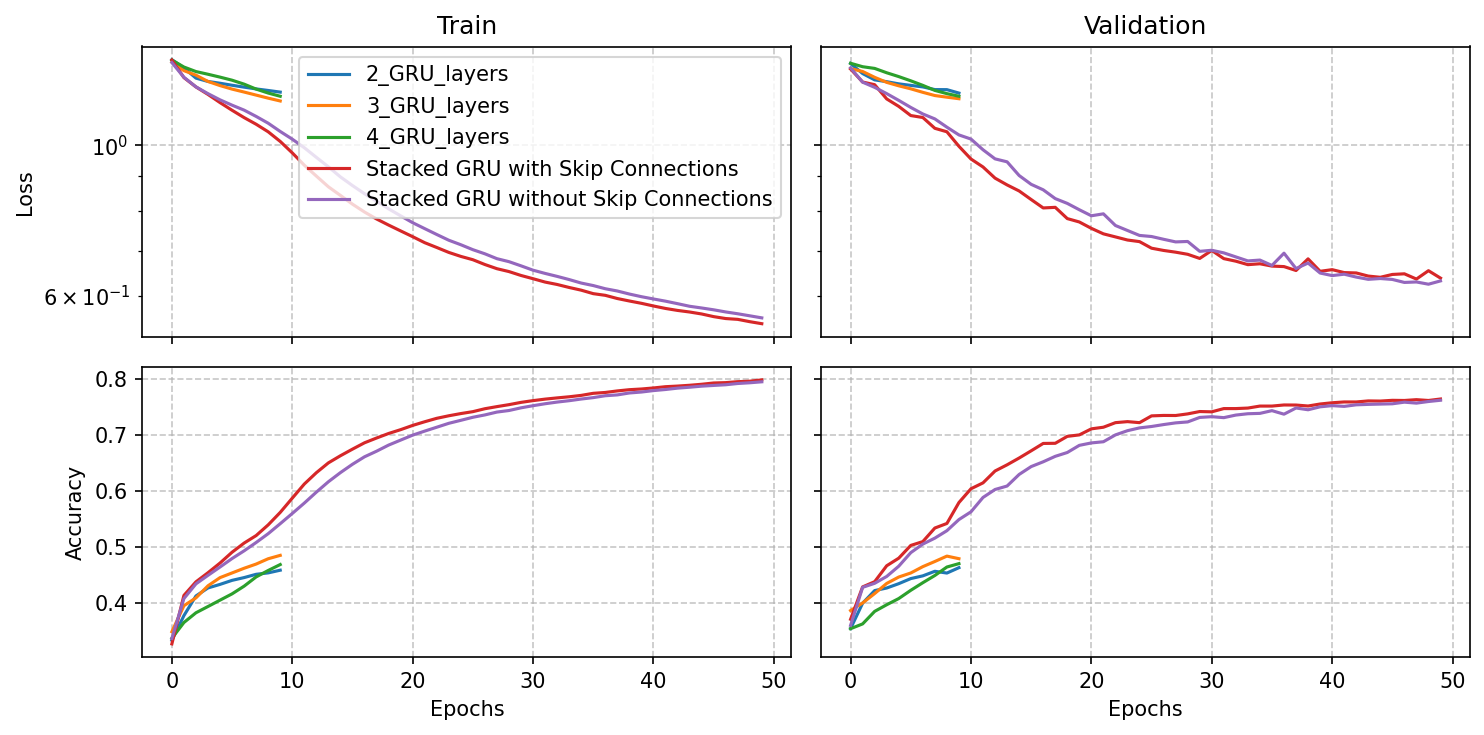

In [20]:
utils.plot_multiple_histories(final_histories, labelsv2)